<a href="https://colab.research.google.com/github/aderdouri/PINNs/blob/master/burgers_equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Burgers equation:
## Problem setup

We will solve a Burgers' equation:

$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}, \quad x \in [-1, 1], \quad t \in [0, 1]
$$

with the Dirichlet boundary conditions and initial conditions:

$$
u(-1, t) = u(1, t) = 0, \quad u(x, 0) = -\sin(\pi x).
$$

The reference solution is \href{#}{here}.


## Implementation

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
# Step 1: Define the PDE
def f(x):
    """Source term f(x)."""
    return torch.sin(np.pi * x)  # Example source term

# Step 2: Define the PINN model
class PINN(nn.Module):
    """Physics-Informed Neural Network."""
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layers = nn.Sequential(
            nn.Linear(1, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.hidden_layers(x)

# Step 3: Define the loss function
def compute_loss(model, x_interior, x_boundary):
    """Compute the combined loss for the PDE residual and boundary conditions."""
    x_interior.requires_grad = True
    u = model(x_interior)
    u_x = torch.autograd.grad(u, x_interior, grad_outputs=torch.ones_like(u),
                              create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x_interior, grad_outputs=torch.ones_like(u_x),
                               create_graph=True)[0]

    # PDE residual loss
    f_values = f(x_interior)
    pde_loss = torch.mean((u_xx + f_values) ** 2)

    # Boundary condition loss
    u_boundary = model(x_boundary)
    bc_loss = torch.mean(u_boundary ** 2)

    return pde_loss + bc_loss

# Step 4: Training the model
def train_pinn(model, x_interior, x_boundary, adam_epochs=1000, lbfgs_epochs=500):
    """Train the PINN model using Adam and LBFGS optimizers."""
    # Adam optimizer for initial training
    optimizer_adam = torch.optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(adam_epochs):
        optimizer_adam.zero_grad()
        loss = compute_loss(model, x_interior, x_boundary)
        loss.backward()
        optimizer_adam.step()
        if epoch % 100 == 0:
            print(f"Adam Epoch {epoch}, Loss: {loss.item()}")

    # LBFGS optimizer for fine-tuning
    optimizer_lbfgs = torch.optim.LBFGS(model.parameters(),
                                        max_iter=lbfgs_epochs,
                                        tolerance_grad=1e-7,
                                        tolerance_change=1e-9)

    def closure():
        optimizer_lbfgs.zero_grad()
        loss = compute_loss(model, x_interior, x_boundary)
        loss.backward()
        return loss

    print("Starting LBFGS optimization...")
    optimizer_lbfgs.step(closure)

In [3]:
# Step 5: Generate training data
x_interior = torch.linspace(0, 1, 100).view(-1, 1)
x_boundary = torch.tensor([[0.0], [1.0]], dtype=torch.float32)

# Step 6: Initialize and train the PINN
model = PINN()
train_pinn(model, x_interior, x_boundary)

Adam Epoch 0, Loss: 0.5175182819366455
Adam Epoch 100, Loss: 0.001213669776916504
Adam Epoch 200, Loss: 0.0009185169474221766
Adam Epoch 300, Loss: 0.0008068199385888875
Adam Epoch 400, Loss: 0.0007126311538740993
Adam Epoch 500, Loss: 0.0006244599353522062
Adam Epoch 600, Loss: 0.0005409460281953216
Adam Epoch 700, Loss: 0.00046119021135382354
Adam Epoch 800, Loss: 0.0003842061560135335
Adam Epoch 900, Loss: 0.0003093395789619535
Starting LBFGS optimization...


In [4]:
# Step 7: Visualize the solution
x_test = torch.linspace(0, 1, 100).view(-1, 1)
u_pred = model(x_test).detach().numpy()

# Exact solution for comparison
def exact_solution(x):
    return (1 / (np.pi ** 2)) * np.sin(np.pi * x)

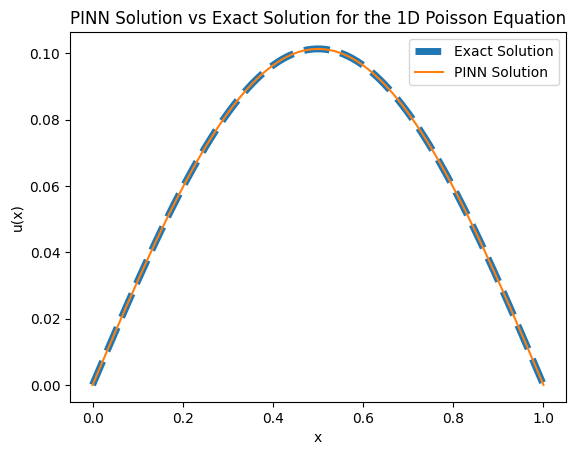

In [5]:
x_exact = x_test.numpy().flatten()
u_exact = exact_solution(x_exact)

plt.plot(x_exact, u_exact, label='Exact Solution', linestyle='dashed', linewidth=5)
plt.plot(x_test.numpy(), u_pred, label='PINN Solution')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('PINN Solution vs Exact Solution for the 1D Poisson Equation')
plt.legend()
plt.show()
